In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import pandas
import seaborn as sns 
from sklearn import preprocessing
import nltk 
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from collections import Counter 
import re
import string
import matplotlib.cm as cm
from matplotlib import rcParams
from prettytable import PrettyTable
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
pd.options.display.float_format = "{:.2f}".format

In [3]:
final_data=pd.read_csv("all_data.csv")
final_data.head()

,Unnamed: 0,text,sentiment
0,0,﻿حقا\n,pos
1,1,صح جدا\n,pos
2,2,﻿اه و النعمة \n,pos
3,3,كلامك جميل ورائع\n,pos
4,4,﻿و خير الكلام ما قل و دل\n,pos


In [4]:
final_data = final_data.drop('Unnamed: 0',axis=1)
final_data.head()

,text,sentiment
0,﻿حقا\n,pos
1,صح جدا\n,pos
2,﻿اه و النعمة \n,pos
3,كلامك جميل ورائع\n,pos
4,﻿و خير الكلام ما قل و دل\n,pos


In [5]:
print("all tweets: ",len(final_data))

all tweets:  156407


In [6]:
final_data['text'].head()

0                        ﻿حقا\n
1                      صح جدا\n
2               ﻿اه و النعمة \n
3            كلامك جميل ورائع\n
4    ﻿و خير الكلام ما قل و دل\n
Name: text, dtype: object

In [7]:
final_data['sentiment'].head(10)

0    pos
1    pos
2    pos
3    pos
4    pos
5    pos
6    pos
7    pos
8    pos
9    pos
Name: sentiment, dtype: object

In [8]:
from sklearn.utils import shuffle
final_data = shuffle(final_data).reset_index()
final_data.head()

,index,text,sentiment
0,59923,خميس يا اخوان ❤ 🎤\n,pos
1,53694,للمقبلين على اختبار موقع لتدريب على اختبار في ...,pos
2,90394,🍃 🌹 🍃 و َ أحيين َ ا الله ُ م َ ّ على س ُ ن ّ ت...,pos
3,125254,رساله من شخص لا تعرفه ولا تعرفك ✋ بس جايه ف وق...,neg
4,85442,بيبي ودي اكلها 💕 💗 💕 💗 💖 💖 💘 💕 💓 💞\n,pos


In [9]:
final_data = final_data.drop('index',axis=1)
final_data.head()

,text,sentiment
0,خميس يا اخوان ❤ 🎤\n,pos
1,للمقبلين على اختبار موقع لتدريب على اختبار في ...,pos
2,🍃 🌹 🍃 و َ أحيين َ ا الله ُ م َ ّ على س ُ ن ّ ت...,pos
3,رساله من شخص لا تعرفه ولا تعرفك ✋ بس جايه ف وق...,neg
4,بيبي ودي اكلها 💕 💗 💕 💗 💖 💖 💘 💕 💓 💞\n,pos


In [10]:
final_data[final_data.isnull().any(axis=1)].head()
np.sum(final_data.isnull().any(axis=1))

0

In [11]:
final_data.isnull().any(axis=0)

text         False
sentiment    False
dtype: bool

In [12]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156407 entries, 0 to 156406
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       156407 non-null  object
 1   sentiment  156407 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


In [13]:
for letter in '#.][!XR':
    final_data['text'] = final_data['text'].astype(str).str.replace(letter,'')

In [14]:
final_data.sample(5)

,text,sentiment
95506,واللي يشتري خاطري 😊 اشتري التراب اللي بيمشي عل...,pos
129690,بمناسبة اليوم العالمي للتطوع شارك ورابح 💵 500 ...,neg
27468,متيكده 😉 مافيه\n,pos
106178,رساله اتمنى تفهموها يااهلاويين وبالذات الاتحاد...,neg
1031,شحوال ضهرك يا بواتينغ 😀 😀\n,pos


In [15]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [16]:
def remove_non_arabic(text):
    return ' '.join(re.sub(u"[^\u0621-\u063A\u0640-\u0652 ]", " ", str(text),  flags=re.UNICODE).split())

In [17]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

In [18]:
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [19]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [20]:
def processPost(tweet): 

    #Replace @username with empty string
    tweet = re.sub('@[^\s]+', ' ', tweet)
    
    #Convert www.* or https?://* to " "
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',tweet)
    
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)

    # remove punctuations
    tweet= remove_punctuations(tweet)
    
    # normalize the tweet
    #tweet= normalize_arabic(tweet)
    
    # remove repeated letters
    #tweet=remove_repeating_char(tweet)


    # remove emoji
    tweet=remove_emoji(tweet)
    
    return tweet

In [21]:
final_data["text"] = final_data['text'].apply(lambda x: processPost(x))

In [22]:
final_data["text"] = final_data['text'].apply(remove_non_arabic)

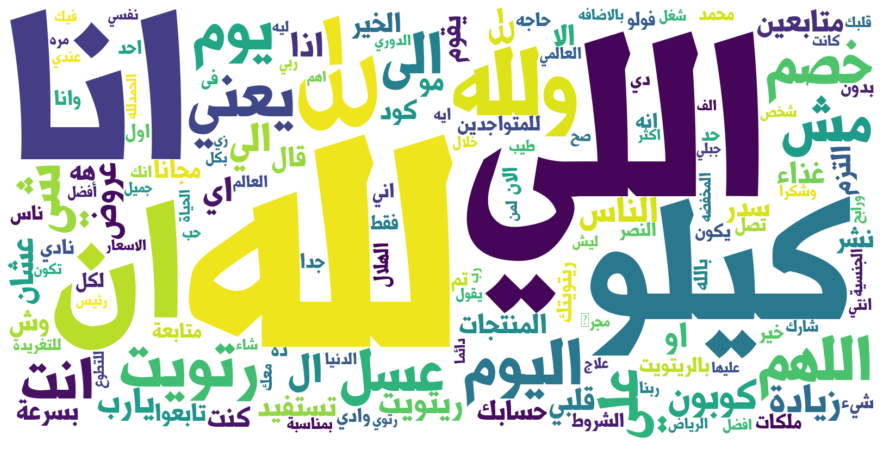

In [23]:
from arabic_reshaper import arabic_reshaper
from bidi.algorithm import get_display
from nltk.corpus import stopwords
from itertools import islice
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


text = " ".join(line for line in final_data['text'])
stop_ar = stopwords.words('arabic') 
# add more stop words here like numbers, special characters, etc. It should be customized for your project

top_words = {}
words = text.split()
for w in words:
    if w in stop_ar:
        continue
    else:
        if w not in top_words:
            top_words[w] = 1
        else:
            top_words[w] +=1

# Sort the dictionary of the most frequent words
top_words = {k: v for k, v in sorted(top_words.items(), key=lambda item: item[1], reverse = True)}

# select the first 150 most frequent words
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))
for_wc = take(150, top_words.items())

# you need to reshape your words to be shown properly and turn the result into a dictionary
dic_data = {}
for t in for_wc:
    r = arabic_reshaper.reshape(t[0]) # connect Arabic letters
    bdt = get_display(r) # right to left
    dic_data[bdt] = t[1] 

# Plot
wc = WordCloud(background_color="white", width=1600, height=800,max_words=400 ,font_path='Shoroq-Font.ttf').generate_from_frequencies(dic_data)
plt.figure(figsize=(16,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


In [24]:
final_data["text"] = final_data['text'].apply(lambda x:remove_repeating_char(x))

In [ ]:
final_data["text"] = final_data['text'].apply(lambda x:normalize_arabic(x))

In [37]:
tokenizer = RegexpTokenizer(r'\w+')
final_data["text"] = final_data["text"].apply(tokenizer.tokenize)

In [38]:
final_data["text"].sample(5)

136888    [توادعنا, بلا, موعد, بعد, ضويت, عشر, شموع, وطف...
633       [عاجل, بعدتعرض, العالمي, لظلم, واضح, ابتدامن, ...
138170    [فاضر, ب, بيد, ك, الي, مني, علي, قلبك, وق, ل, ...
49513     [حصري, هنا, شاهد, الفديو, قبل, الحذف, لاعبدالع...
63001     [ما, توقعت, فيه, ناس, معدوم, الذوق, عندهم, لذي...
Name: text, dtype: object

In [39]:
stopwords_list = stopwords.words('arabic')
stopwords_list

['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'

In [40]:
print(len(stopwords_list))

754


In [41]:
listToStr = ' '.join([str(elem) for elem in stopwords_list])
listToStr

'إذ إذا إذما إذن أف أقل أكثر ألا إلا التي الذي الذين اللاتي اللائي اللتان اللتيا اللتين اللذان اللذين اللواتي إلى إليك إليكم إليكما إليكن أم أما أما إما أن إن إنا أنا أنت أنتم أنتما أنتن إنما إنه أنى أنى آه آها أو أولاء أولئك أوه آي أي أيها إي أين أين أينما إيه بخ بس بعد بعض بك بكم بكم بكما بكن بل بلى بما بماذا بمن بنا به بها بهم بهما بهن بي بين بيد تلك تلكم تلكما ته تي تين تينك ثم ثمة حاشا حبذا حتى حيث حيثما حين خلا دون ذا ذات ذاك ذان ذانك ذلك ذلكم ذلكما ذلكن ذه ذو ذوا ذواتا ذواتي ذي ذين ذينك ريث سوف سوى شتان عدا عسى عل على عليك عليه عما عن عند غير فإذا فإن فلا فمن في فيم فيما فيه فيها قد كأن كأنما كأي كأين كذا كذلك كل كلا كلاهما كلتا كلما كليكما كليهما كم كم كما كي كيت كيف كيفما لا لاسيما لدى لست لستم لستما لستن لسن لسنا لعل لك لكم لكما لكن لكنما لكي لكيلا لم لما لن لنا له لها لهم لهما لهن لو لولا لوما لي لئن ليت ليس ليسا ليست ليستا ليسوا ما ماذا متى مذ مع مما ممن من منه منها منذ مه مهما نحن نحو نعم ها هاتان هاته هاتي هاتين هاك هاهنا هذا هذان هذه هذي هذين هكذا هل هلا هم هما هن هنا هن

In [43]:
final_data["text"]=final_data["text"].apply(lambda x: [item for item in x if item not in stopwords_list])

In [45]:
all_words = [word for tokens in final_data["text"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in final_data["text"]]

VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

1447300 words total, with a vocabulary size of 115185
Max sentence length is 125


In [47]:
#wordcloud
counter = Counter(all_words)
counter.most_common(25)

[('علي', 17915),
 ('الي', 16392),
 ('اله', 15152),
 ('ان', 11006),
 ('انا', 9049),
 ('كيلو', 5186),
 ('واله', 5078),
 ('حتي', 4315),
 ('الان', 3943),
 ('انت', 3916),
 ('او', 3888),
 ('ال', 3881),
 ('رتويت', 3822),
 ('الا', 3821),
 ('اليوم', 3739),
 ('يعني', 3723),
 ('يوم', 3615),
 ('الهم', 3592),
 ('اذا', 3586),
 ('اي', 3417),
 ('خصم', 3327),
 ('مش', 3178),
 ('عسل', 3104),
 ('شي', 2929),
 ('يارب', 2779)]

In [48]:
counted_words = Counter(all_words)

words = []
counts = []
for letter, count in counted_words.most_common(25):
    words.append(letter)
    counts.append(count)

In [50]:
y=final_data['sentiment']
y.value_counts()

pos    93144
neg    63263
Name: sentiment, dtype: int64

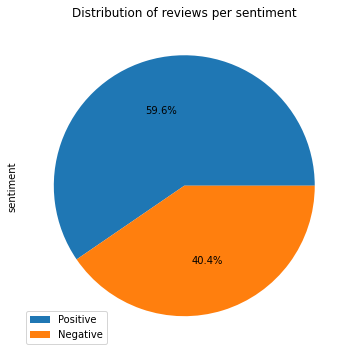

In [52]:
final_data['sentiment'].value_counts().plot.pie(figsize=(6,6),title="Distribution of reviews per sentiment",labels=['',''],autopct='%1.1f%%' )
labels=["Positive","Negative"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')


In [53]:
# 0 = neg and 1 = pos
label_mapping = {"pos": 1, "neg":0}
final_data["sentiment"] = final_data["sentiment"].map(label_mapping)
final_data.head()

,text,sentiment
0,"[مبروك, اله, يجعله, الذريه, الصالحه, يطلع, تقني]",1
1,"[نادي, تطوع, حطوا, ال]",1
2,"[متي, ترجع, لمستواك, فيلانويفا, اشتقت, واله]",0
3,"[بمنشن, نفسي]",0
4,"[صح, يقوم, بالدور, تخلت, عنه, القاده, السعودين...",0


In [73]:
# احسب المصطلجات الفريت

In [55]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 1),
    max_features =10000)

unigramdataGet= word_vectorizer.fit_transform(final_data['text'].astype('str'))
unigramdataGet = unigramdataGet.toarray()

vocab = word_vectorizer.get_feature_names()
unigramdata_features=pd.DataFrame(np.round(unigramdataGet, 1), columns=vocab)
unigramdata_features[unigramdata_features>0] = 1

unigramdata_features.head()

,اء,اب,ابا,اباحه,ابتدامن,ابتدايي,ابتسامتك,ابتسامتها,ابتسامه,ابتسم,...,يومه,يومها,يومي,يوميا,يومين,يوميه,يونس,يونغ,يونقي,يوه
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [56]:
pro= preprocessing.LabelEncoder()
encpro=pro.fit_transform(final_data['sentiment'])
final_data['sentiment'] = encpro

In [57]:
y=final_data['sentiment']
X=unigramdata_features

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

In [59]:
y_test.value_counts()

1    18688
0    12594
Name: sentiment, dtype: int64

In [60]:
y_train.value_counts()



1    74456
0    50669
Name: sentiment, dtype: int64

In [61]:
print("Train Size: ", len(X_train))
print("Test Size:  ", len(X_test))

Train Size:  125125
Test Size:   31282


In [62]:
#ensemble model python code
nb=GaussianNB()
nb= nb.fit(X_train , y_train)
nb

GaussianNB()

In [63]:

y_pred = nb.predict(X_test)
nb_1=nb.score(X_test, y_test)
print('Accuracy= {:.3f}'.format(nb.score(X_test, y_test)))

Accuracy= 0.597


In [64]:
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.50      0.89      0.64     12594
           1       0.84      0.40      0.54     18688

    accuracy                           0.60     31282
   macro avg       0.67      0.64      0.59     31282
weighted avg       0.70      0.60      0.58     31282



In [65]:
RC= RidgeClassifier()
RC= RC.fit(X_train , y_train)
RC

RidgeClassifier()

In [66]:
y_pred = RC.predict(X_test)
rc_1=RC.score(X_test, y_test)
print('Accuracy= {:.3f}'.format(RC.score(X_test, y_test)))

Accuracy= 0.729


In [67]:
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.72      0.54      0.62     12594
           1       0.73      0.85      0.79     18688

    accuracy                           0.73     31282
   macro avg       0.73      0.70      0.70     31282
weighted avg       0.73      0.73      0.72     31282



In [68]:
LR= LogisticRegression(penalty = 'l2', C = 1)
LR= LR.fit(X_train , y_train)
LR

LogisticRegression(C=1)

In [69]:
y_pred = LR.predict(X_test)
lr_1=LR.score(X_test, y_test)
print('Accuracy= {:.3f}'.format(LR.score(X_test, y_test)))

Accuracy= 0.731


In [70]:
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.72      0.54      0.62     12594
           1       0.74      0.86      0.79     18688

    accuracy                           0.73     31282
   macro avg       0.73      0.70      0.71     31282
weighted avg       0.73      0.73      0.72     31282



In [71]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=10)
clf= clf.fit(X_train , y_train)
clf

RandomForestClassifier(n_estimators=10)

In [72]:
y_pred = clf.predict(X_test)
clf_1=clf.score(X_test, y_test)
print('Accuracy= {:.3f}'.format(clf.score(X_test, y_test)))

Accuracy= 0.777


In [73]:
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.74      0.69      0.71     12594
           1       0.80      0.84      0.82     18688

    accuracy                           0.78     31282
   macro avg       0.77      0.76      0.77     31282
weighted avg       0.78      0.78      0.78     31282



In [74]:
x = PrettyTable()
print('\n')
print("Comparison of all algorithms on F1 score")
x.field_names = ["Model", "F1"]


x.add_row(["Naive Bayes Algorithm", round(nb_1,2)])
x.add_row(["Ridge Classifier Algorithm",  round(rc_1,2)])
x.add_row(["Logistic Regression Algorithm", round(lr_1,2)])
x.add_row(["Random Forest Algorithm", round(clf_1,2)])

print(x)
print('\n')



Comparison of all algorithms on F1 score
+-------------------------------+------+
|             Model             |  F1  |
+-------------------------------+------+
|     Naive Bayes Algorithm     | 0.6  |
|   Ridge Classifier Algorithm  | 0.73 |
| Logistic Regression Algorithm | 0.73 |
|    Random Forest Algorithm    | 0.78 |
+-------------------------------+------+




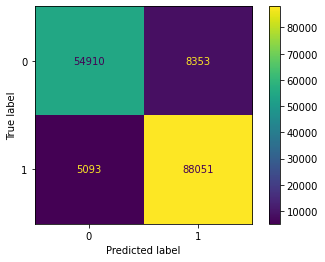

In [78]:
#clf=RandomForestClassifier(n_estimators=10)
#clf= clf.fit(X_train , y_train)

# make predictions with your classifier
y_pred = clf.predict(X)         
# optional: get true negative (tn), false positive (fp)
# false negative (fn) and true positive (tp) from confusion matrix
M = confusion_matrix(y, y_pred)
tn, fp, fn, tp = M.ravel() 
# plotting the confusion matrix
plot_confusion_matrix(clf, X, y)
plt.show()

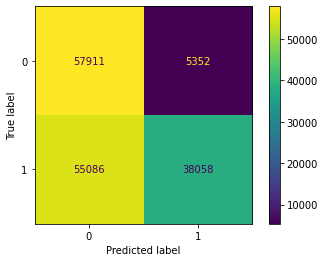

In [79]:
#nb = nb=GaussianNB()
#nb.fit(X_train , y_train) # fit your classifier

# make predictions with your classifier
y_pred = nb.predict(X)         
# optional: get true negative (tn), false positive (fp)
# false negative (fn) and true positive (tp) from confusion matrix
M = confusion_matrix(y, y_pred)
tn, fp, fn, tp = M.ravel() 
# plotting the confusion matrix
plot_confusion_matrix(nb, X, y)
plt.show()

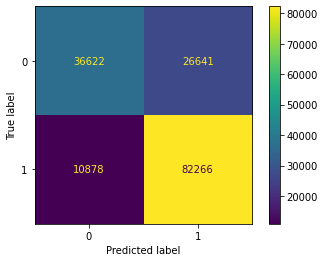

In [80]:
#LR= LogisticRegression(penalty = 'l2', C = 1)
#LR= LR.fit(X_train , y_train)

# make predictions with your classifier
y_pred = LR.predict(X)         
# optional: get true negative (tn), false positive (fp)
# false negative (fn) and true positive (tp) from confusion matrix
M = confusion_matrix(y, y_pred)
tn, fp, fn, tp = M.ravel() 
# plotting the confusion matrix
plot_confusion_matrix(LR, X, y)
plt.show()

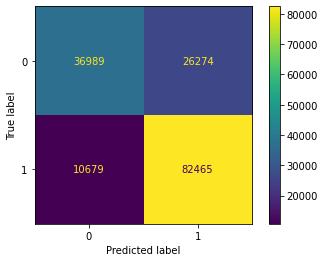

In [81]:
#RC= RidgeClassifier()
#RC.fit(X_train , y_train) # fit your classifier

# make predictions with your classifier
y_pred = RC.predict(X)         
# optional: get true negative (tn), false positive (fp)
# false negative (fn) and true positive (tp) from confusion matrix
M = confusion_matrix(y, y_pred)
tn, fp, fn, tp = M.ravel() 
# plotting the confusion matrix
plot_confusion_matrix(RC, X, y)
plt.show()